In [1]:
include("../src/celerite.jl")
include("../TransitModel/transit.jl")
using Plots
using Statistics
using ForwardDiff
using LaTeXStrings
using LinearAlgebra
using DelimitedFiles
#Plots.scalefontsizes(1.5)

In [31]:
function trapezoidal_transit(t, t0, r, d, tin)
    trans = zeros(Real, length(t))
    t1 = (t0-d/2-tin)
    t2 = (t0-d/2)
    t3 = (t0+d/2)
    t4 = (t0+d/2+tin)
    intransit = (t.<=t3).&(t.>=t2)
    ingress = (t.<t2).&(t.>t1)
    egress = (t.<t4).&(t.>t3)
    trans[intransit] .= -(r^2)
    trans[ingress] .= -(t[ingress].-t1)*(r^2)/tin
    trans[egress] .= (1 - (r^2)).+(t[egress].-t3)*(r^2)/tin.-1
    return trans
end

function get_derivative(t, x0, p)
    if p == nothing
        d = transit(t, x0...)[1]
    else
        df = @eval (t, t0, b0, rp, d, u) -> ForwardDiff.derivative($p -> transit(t, t0, b0, rp, d, u)[1], $p)
        d = Base.invokelatest(df, t, x0...)
    end
    return d
end

function get_derivative_trapezoid(t, x0, p)
    if p == nothing
        d = transit(t, x0...)[1]
    else
        df = @eval (t, t0, rp, d, tin) -> ForwardDiff.derivative($p -> trapezoidal_transit(t, t0, rp, d, tin), $p)
        d = Base.invokelatest(df, t, x0...)
    end
    return d
end

function fisher(t, gp, df, log_wn=nothing)
    m = length(gp.Q[1,:])
    n = length(t)
    if log_wn != nothing
        if m > 1 
            wn_vec = zeros(n*m)
            df = kron(df, ones(m))
            for i in 1:m
                wn_vec[i:m:end] .= exp(log_wn[i]) 
            end
        else
            wn_vec = exp(log_wn)
        end
        celerite.compute!(gp, t, wn_vec)
    else
        if m > 1
            df = kron(df, ones(m))
        end
    end
    return df'*celerite.apply_inverse(gp, df)
end

function make_gp(t, log_s, log_w0, log_var; bins=nothing, A0=nothing, ds0dlam=1, c=nothing)
    if bins != nothing 
        f = [sum(bins[1:i]) for i in 0:length(bins)]
        var = [exp(log_var)/b for b in bins]
        if c == nothing
            c = [(A0+ds0dlam*(f[i+1]+f[i]))/(A0+ds0dlam*(2*sum(f[2:end-1])+1)) for i in 1:length(bins)]*length(bins)
        else
            c = c./mean(c)
        end
        m = length(c)
        Q = broadcast(*, c, c')
        wn_vec = zeros(length(t)*m)
        for i in 1:m
            wn_vec[i:m:end] .= sqrt.(var[i]) 
        end
    else
        Q = ones(1, 1)
        c = nothing
    end
    log_q = log(1/sqrt(2))
    if bins != nothing
        gp = celerite.Celerite(celerite.SHOTerm(log_s, log_q, log_w0), Q)
        logD = celerite.compute!(gp, t, wn_vec)
    else
        gp = celerite.Celerite(celerite.SHOTerm(log_s, log_q, log_w0))
        logD = celerite.compute!(gp, t, exp.(0.5*log_var))
    end
    return gp, c
end

make_gp (generic function with 1 method)

In [ ]:
# make plots fisher_uncertainty_params_1 and fisher_uncertainty_params_2
# which show the fisher uncertainty for rp, d, and t0 as a function 
# of the correlated noise - white noise amplitude ratio 
# change w0T to get different noise regimes 

t = collect(-4:0.01:4)

t0 = 0
b0 = 0
rp = 0.5
d = 1
tin = d/3
u = [0.5, 0.5]
x0 = [t0, b0, rp, d, u]

log_s = -20
w0T = 0.1
log_w0 = log(w0T) - log(d)

log_var = collect(-32:0.5:-5)

polyerr = zeros(length(log_var))
monoerr = zeros(length(log_var))
# should be exact variance for linear parameter rp 

for param in [:rp, :d, :t0]
    df = get_derivative(t, x0, param)
    for (i, lv) in enumerate(log_var)
        bins = [0.5, 0.5]
        polygp, c = make_gp(t, log_s-log_w0, log_w0, lv, bins)
        monogp, trash = make_gp(t, log_s-log_w0, log_w0, lv)
        polyerr[i] = 1/sqrt(fisher(t, polygp, df))
        monoerr[i] = 1/sqrt(fisher(t, monogp, df))
    end
    writedlm("plot_data/fisher_information/$(param)_$(w0T).dat", [monoerr, polyerr])
end
x = log_s.-log_w0 .- log_var
writedlm("plot_data/fisher_uncertainty_corr_wn_ratio.dat", x)

In [ ]:
# read and plot data generated above for fisher_uncertainty_params plots 

rp_mono, rp_poly = [readdlm("plot_data/fisher_information/rp_0.1.dat")[i,:] for i in 1:2]./rp
t0_mono, t0_poly = [readdlm("plot_data/fisher_information/t0_0.1.dat")[i,:] for i in 1:2]
t0_mono, t0_poly = (t0_mono)./d, (t0_poly)./d
d_mono, d_poly = [readdlm("plot_data/fisher_information/d_0.1.dat")[i,:] for i in 1:2]./d

plot(x, log10.(rp_mono), linewidth=3, 
    color=palette(:dark)[1], 
    linestyle=:dash,
    label="")

plot!(x, log10.(t0_mono), linewidth=3, 
    color=palette(:dark)[2],
    linestyle=:dash,
    label="")

plot!(x, log10.(d_mono), linewidth=3, 
    color=palette(:dark)[5],
    linestyle=:dash,
    label="")

plot!(x, log10.(rp_poly), linewidth=3, 
    color=palette(:dark)[1], 
    label=L"R_p/R_*")

plot!(x, log10.(t0_poly), linewidth=3, 
    color=palette(:dark)[2], 
    label=L"t_0")

plot!(x, log10.(d_poly), linewidth=3,
    legend=true, 
    color=palette(:dark)[5],
    label=L"\Delta T", 
    xlabel=L"\mathrm{log}(A_\mathrm{corr}/A_\mathrm{wn})", 
    ylabel=L"\mathrm{log}(\sigma/\mu)",
    framestyle=:box,
    annotations=(-5, -6.5, L"\log({\omega_0\Delta T) = 1}", 20)
)

In [73]:
# make plots fisher_uncertainty_c_1 and fisher_uncertainty_c_2 
# which demonstrate the uncertainty ratio poly/mono for varying the scaling 
# c between bands in two different noise regimes (w0T=10 and w0T=0.1)

t = collect(-4:0.01:4)

t0 = 0
b0 = 0
rp = 0.5
d = 1
tin = d/3
u = [0.5, 0.5]
x0 = [t0, b0, rp, d, u]

log_s = -20
w0T = 0.1
log_w0 = log(w0T) - log(d)

# high correlated noise limit 
log_var = -30
#binfrac = collect(0.1:0.1:1)
c = collect(1:0.1:10)

polyerr = zeros(length(c))
monoerr = zeros(length(c))
# should be exact variance for linear parameter rp 

for param in [:rp, :d, :t0]
    df = get_derivative(t, x0, param)
    for (i, c) in enumerate(c)
        scales = [1, c]
        polygp, trash = make_gp(t, log_s-log_w0, log_w0, log_var, bins=[0.5, 0.5], c=scales)
        monogp, trash = make_gp(t, log_s-log_w0, log_w0, log_var)
        polyerr[i] = 1/sqrt(fisher(t, polygp, df))
        monoerr[i] = 1/sqrt(fisher(t, monogp, df))
    end
    writedlm("plot_data/fisher_information/bins_$(param)_$(w0T).dat", [monoerr, polyerr])
end
x = c
writedlm("plot_data/fisher_information/fisher_uncertainty_scale_factors.dat", x)

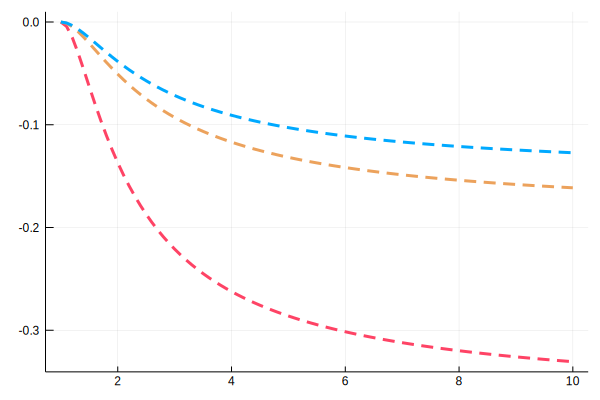

In [74]:
# plot the above 

rp_mono, rp_poly = [readdlm("plot_data/fisher_information/bins_rp_0.1.dat")[i,:] for i in 1:2]./rp
t0_mono, t0_poly = [readdlm("plot_data/fisher_information/bins_t0_0.1.dat")[i,:] for i in 1:2]
t0_mono, t0_poly = (t0_mono)./d, (t0_poly)./d
d_mono, d_poly = [readdlm("plot_data/fisher_information/bins_d_0.1.dat")[i,:] for i in 1:2]./d

plot(x, log10.(rp_poly).-log10.(rp_mono), linewidth=3, 
    color=palette(:dark)[1], 
    linestyle=:dash,
    label="")

plot!(x, log10.(t0_poly).-log10.(t0_mono), linewidth=3, 
    color=palette(:dark)[2],
    linestyle=:dash,
    label="")

plot!(x, log10.(d_poly).-log10.(d_mono), linewidth=3, 
    color=palette(:dark)[5],
    linestyle=:dash,
    label="")

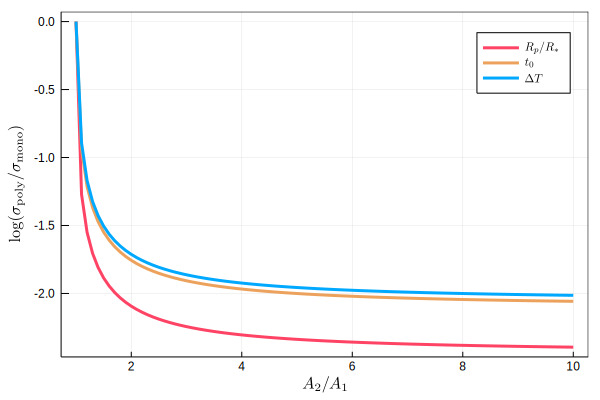

In [107]:
# plot the above 

rp_mono, rp_poly = [readdlm("plot_data/fisher_information/bins_rp_10.dat")[i,:] for i in 1:2]./rp
t0_mono, t0_poly = [readdlm("plot_data/fisher_information/bins_t0_10.dat")[i,:] for i in 1:2]
t0_mono, t0_poly = (t0_mono)./d, (t0_poly)./d
d_mono, d_poly = [readdlm("plot_data/fisher_information/bins_d_10.dat")[i,:] for i in 1:2]./d
x = readdlm("plot_data/fisher_information/fisher_uncertainty_scale_factors.dat")

plot(x, log10.(rp_poly).-log10.(rp_mono), linewidth=3, 
    color=palette(:dark)[1], 
    label=L"R_p/R_*")

plot!(x, log10.(t0_poly).-log10.(t0_mono), linewidth=3, 
    color=palette(:dark)[2],
    label=L"t_0")

plot!(x, log10.(d_poly).-log10.(d_mono), linewidth=3, 
    color=palette(:dark)[5],
    label=L"\Delta T",
    xlabel=L"A_2/A_1",
    ylabel=L"\mathrm{log}(\sigma_\mathrm{poly}/\sigma_\mathrm{mono})",
    framestyle=:box)

In [ ]:
# make plot fisher_uncerainty_nbands which demonstrates how the uncertainty changes 
# as bands are added 


In [119]:
t = collect(-4:0.01:4)

t0 = 0
b0 = 0
rp = 0.5
d = 1
tin = d/3
u = [0.5, 0.5]
x0 = [t0, b0, rp, d, u]

log_s = -20
w0T = 10
log_w0 = log(w0T) - log(d)

# high correlated noise limit 
log_var = -30
#binfrac = collect(0.1:0.1:1)
nbands = collect(1:1:20)

polyerr = zeros(length(nbands))
monoerr = zeros(length(nbands))
# should be exact variance for linear parameter rp 

for param in [:rp, :d, :t0]
    df = get_derivative(t, x0, param)
    for (i, nb) in enumerate(nbands)
        if nb == 1
            scales = [1]
        else
            scales = collect(1:1:nb)
        end
        #println(scales/mean(scales))
        polygp, trash = make_gp(t, log_s-log_w0, log_w0, log_var, bins=(1/nb)*ones(nb), c=scales)
        monogp, trash = make_gp(t, log_s-log_w0, log_w0, log_var)
        polyerr[i] = 1/sqrt(fisher(t, polygp, df))
        monoerr[i] = 1/sqrt(fisher(t, monogp, df))
    end
    writedlm("plot_data/fisher_information/nbins_$(param)_$(w0T).dat", [monoerr, polyerr])
end
x = nbands

20-element Array{Int64,1}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20

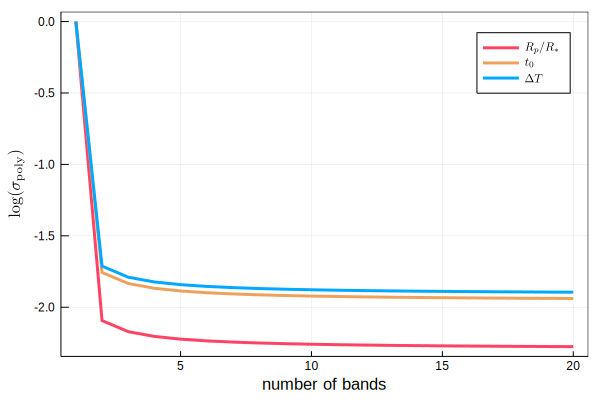

In [121]:
rp_mono, rp_poly = [readdlm("plot_data/fisher_information/nbins_rp_10.dat")[i,:] for i in 1:2]./rp
t0_mono, t0_poly = [readdlm("plot_data/fisher_information/nbins_t0_10.dat")[i,:] for i in 1:2]
t0_mono, t0_poly = (t0_mono)./d, (t0_poly)./d
d_mono, d_poly = [readdlm("plot_data/fisher_information/nbins_d_10.dat")[i,:] for i in 1:2]./d

plot(x, log10.(rp_poly).-log10.(rp_mono), linewidth=3, 
    color=palette(:dark)[1], 
    label=L"R_p/R_*")

plot!(x, log10.(t0_poly).-log10.(t0_mono), linewidth=3, 
    color=palette(:dark)[2],
    label=L"t_0")

plot!(x, log10.(d_poly).-log10.(d_mono), linewidth=3, 
    color=palette(:dark)[5],
    label=L"\Delta T",
    xlabel="number of bands",
    ylabel=L"\mathrm{log}(\sigma_\mathrm{poly})",
    framestyle=:box)